<a href="https://colab.research.google.com/github/VincentCsNv/SPARKS/blob/main/Classification_CIFAR/classif_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision --quiet
!pip install sympy==1.13.1 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 34.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires sympy>=1.13.3, but you have sympy 1.13.1 which is incompatible.


In [36]:
import os
import torch
from tqdm import tqdm
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision.datasets import CIFAR100
from sklearn.metrics import confusion_matrix, classification_report
import torchvision.transforms as tt
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns



In [4]:
super_class_dict = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

In [3]:
#PARAMETERS
SUPER_CLASSES = ["aquatic mammals","household furniture","trees"]
GPU = False #To use the GPU or CPU.


# 1. Prepare the dataset (CIFAR 100) :

In [5]:
#Useful functions :
#Sort Dataset
def getting_classes_selected(superclass_selected,superclass_dict):
  '''
  Function to get the classes associated to an ensemble of superclasses
  '''
  classes_selected = []
  for superclass in superclass_selected:
    classes_selected = classes_selected + super_classes_dict[superclass]
  return classes_selected

def get_idx_classes(class_selected,data):
  return data.class_to_idx[class_selected]


def getting_subset_df(data,super_class_dict,SUPER_CLASSES):
  '''
  creating a dataframe with idx of images associated to the SUPER_CLASSES
  '''
  data_df = pd.DataFrame()
  data_df["id_img"] = np.arange(len(data))
  data_df["label"] = data.targets
  data_df["class"] = data_df["label"].apply(lambda x : data.classes[x])

  super_class_df =  pd.DataFrame([
      {'class': class_name, 'superclass': super_class}
      for super_class, classes in super_class_dict.items()
      for class_name in classes
  ])
  data_df = data_df.merge(super_class_df, on='class', how="left")
  #Sort by superclasses
  data_df = data_df[data_df["superclass"].isin(SUPER_CLASSES)]
  return data_df

def get_eq_df(train_df,SUPER_CLASSES):
  '''
  Dataframe of equivalence, according to the different level of labels.
  '''
  eq_df = pd.DataFrame(columns=['class','superclass'])
  eq_df['label'] = train_df["label"].unique()
  eq_df['class'] = eq_df["label"].apply(lambda x : train_df[train_df["label"]== x]["class"].values[0] )
  eq_df['superclass'] = eq_df["class"].apply(lambda x : train_df[train_df["class"]== x]["superclass"].values[0] )
  eq_df = eq_df.sort_values(by="superclass")
  eq_df["label_A"] = eq_df["superclass"].apply(lambda superclass : SUPER_CLASSES.index(superclass) )
  eq_df["label_B"] = np.arange(len(eq_df))
  return eq_df

#Test/ Visualization
def transform_visualisation(data):
  '''
  Test and visualize the transformation apply on the images
  '''
  plt.figure(figsize=(5, 3))
  for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = data[0][0].permute(1, 2, 0) #permute columns to have the great order.
    img=img*0.5 +0.5 #We denormalize the img
    plt.imshow(img)

def histogram_data_df(class_cat,train_df,test_df):
  '''
  plot the repartition of images per class_cat
  '''
  #Count repartition of images
  rep_class_train = train_df[class_cat].value_counts()
  rep_class_test = test_df[class_cat].value_counts()
  #plot histogram
  rep_class_train.plot(kind='bar',color="skyblue",label="training set")
  rep_class_test.plot(kind='bar',color="orange", label = "test set")
  plt.title(f"Repartition of images per {class_cat}")
  plt.legend()
  plt.xlabel('Classes')
  plt.ylabel('Number of images')
  plt.show()


def show_img(sub_data,data,random = True):
  '''
  show a sample of the dataset
  '''
  plt.figure(figsize=(6, 3))

  if random:
    img_idx = np.random.randint(0, len(sub_data),25)
  else:
    img_idx = np.arange(25)


  for i in range(8):
      idx = img_idx[i]
      plt.subplot(2, 4, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img = sub_data[idx][0].permute(1, 2, 0) #permute columns to have the great order.
      img=img*0.5 +0.5 #We denormalize the img
      plt.imshow(img)
      plt.title(data.classes[sub_data[idx][1]])


In [6]:
#DATA AUGMENTATION
#Random transformation for the training (data Augmentation)
train_transform = tt.Compose(
    [tt.RandomHorizontalFlip(),
     #tt.RandomVerticalFlip(),
     tt.RandomRotation(10),
     #ADD Transformation
     tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # EXPLAIN DEVDEVDEV

#For the test we want to avoid random layer, to keep relevant results
test_transform = tt.Compose(
    [tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
# Load CIFAR dataset
train_data = CIFAR100(root="data",download = True, transform = train_transform) #Adding Data Augmentation with transform
test_data = CIFAR100(root="data",train = False,download = True, transform = test_transform) #Adding Data Augmentation with transform

#Getting subset dataframe
train_df = getting_subset_df(train_data,super_class_dict,SUPER_CLASSES)
test_df = getting_subset_df(test_data,super_class_dict,SUPER_CLASSES)
eq_df = get_eq_df(train_df,SUPER_CLASSES)

#Getting subset
trainset = torch.utils.data.Subset(train_data, train_df["id_img"].values)
testset = torch.utils.data.Subset(test_data, test_df["id_img"].values)

print(f"nb of training images {len(trainset)}, nb of test images {len(testset)}")

100%|██████████| 169M/169M [00:03<00:00, 51.8MB/s]


nb of training images 7500, nb of test images 1500


Visualization of a sample of the dataset :


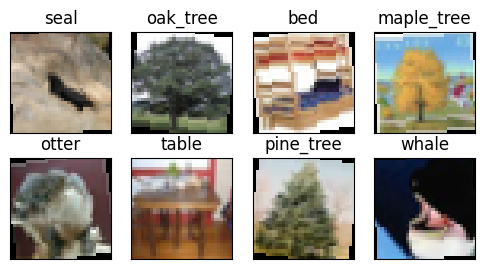

In [8]:
#Observe the dataset
print("Visualization of a sample of the dataset :")
show_img(trainset,train_data, random = True)

Visualization of random transformation on an image


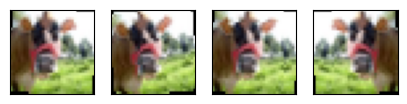

In [9]:
#Observe random transformation :
print("Visualization of random transformation on an image")
transform_visualisation(train_data)

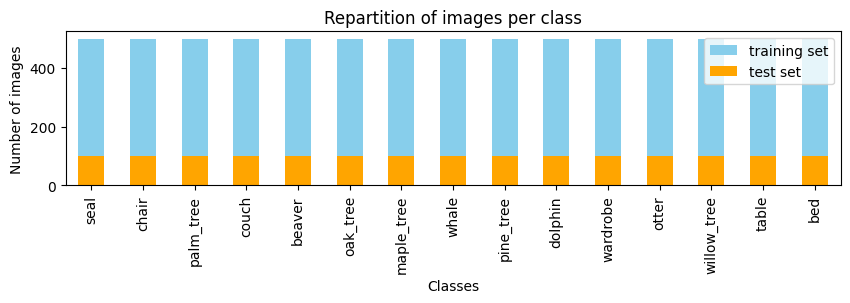

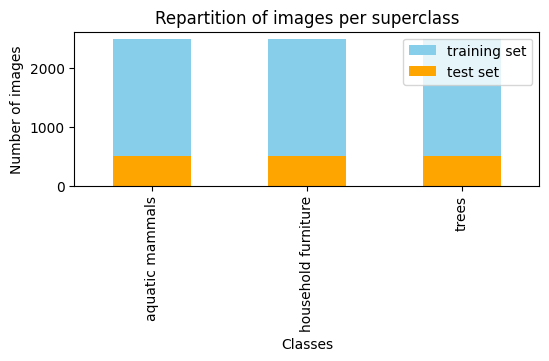

In [10]:
#Histogram repartion per class
plt.figure(figsize=(10, 2))
histogram_data_df("class",train_df,test_df)
#Histogram repartition per superclass
plt.figure(figsize=(6, 2))
histogram_data_df("superclass",train_df,test_df)

# 2. Training models :

## A. Classification in super-classes :

In [11]:
#Add some functions to move to GPU
#Move from CPU to GPU
def check_device():
  '''
  check if cuda is available
  '''
  if torch.cuda.is_available:
      return torch.device('cuda')
  else:
      return torch.device('cpu')

# Function to transfer from CPU to GPU
def move_device(tensor, device):
    '''
    Function to transfer tensor from CPU to GPU
    '''
    # Move all individual tensors from cpu to gpu
    if isinstance(tensor, (list,tuple)):
        return [move_device(element, device) for element in tensor]
    return tensor.to(device, non_blocking=True)

# Execute transfer from CPU to GPU for each device
class DeviceDataLoader():
    '''
    Transfer dataloader form CPU to GPU
    '''
    # Define Constructor
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device

    def __iter__(self):

       # Transfer each batch and return
        for i in self.dl:
            yield move_device(i, self.device)

    def __len__(self):

        # Return the number of batches
        return len(self.dl)

device = check_device() #Assign device of GPU

### a. Define models :

In [15]:
#Model Convolutional layer,lightweight and efficient.
class convnet_no_dropout(nn.Module):
    # Constructor
    def __init__(self,nb_class):
        super(convnet_no_dropout, self).__init__()
        '''
         Convolutional layers
         Conv2d (input channels, output channels, kernel_size, padding)
        '''
        self.nb_class = nb_class

        self.conv_layer_1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer_3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer_4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        # Fully Connected layers
        self.hidden_layer = nn.Linear(128*2*2, 256)
        self.output_layer = nn.Linear(256, self.nb_class) #Size to modify.

        #Dropout to avoid over-fitting :
        self.dropout_layer = nn.Dropout(p=0.2) #

    def forward(self, ip):

        # Calling all the convolutional layers
        output = self.conv_layer_1(ip) #Img 32*32 => 16*16
        output = self.conv_layer_2(output) #Img 16*16 => 8*8
        output = self.conv_layer_3(output) #Img 8*8 => 4*4
        output = self.conv_layer_4(output) #IMG 4*4 => 2*2

        # Flattening
        output = output.view(-1, 128*2*2)

        # Call fully connected layer
        output = self.hidden_layer(output)

        output = self.dropout_layer(output) #Dropout to avoid over-fitting, dropout will be desactivated in evaluation mode.

        output=self.output_layer(output)

        return output


## B. Training:




In [13]:
def convert_labels(labels,eq_df,old_label,new_label,GPU=False):
  '''
  Aim convert labels according to the equivalence df.
  '''
  labels_list = labels.tolist()
  new_labels = [eq_df[eq_df[old_label]== label_nb][new_label].values[0] for label_nb in labels_list]
  new_labels_tensor = torch.tensor(new_labels)
  if GPU:
    new_labels_tensor = move_device(new_labels_tensor, device)
  return new_labels_tensor

def accuracy(outputs, labels, GPU='False'):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item()/len(preds))
    if GPU:
      acc = move_device(acc, device)
    return acc

def accuracy_B(outputs, labels,GPU="False"):
    _, preds = torch.max(outputs, dim=1)
    #convert label to superclasses
    preds_B = convert_labels(preds,eq_df,old_label = "label_B",new_label = "label_A") # Convert from label at the class, and label at the superclass.
    labels_B = convert_labels(labels,eq_df,old_label = "label_B",new_label = "label_A")
    acc = torch.tensor(torch.sum(preds_B == labels_B).item()/len(preds))
    if GPU:
      acc = move_device(acc, device)
    return acc

def evaluate(model,valid_dl,loss_func,mode = "A"):
    model.eval()
    batch_losses, batch_accs=[],[]
    for images,labels in valid_dl:
        labels = convert_labels(labels,eq_df,old_label = "label",new_label = f"label_{mode}",GPU= GPU)
        predicted=model(images)
        batch_losses.append(loss_func(predicted,labels))
        if mode == "A":
          batch_accs.append(accuracy(predicted,labels,GPU = GPU))
        elif mode == "B":
          batch_accs.append(accuracy_B(predicted,labels, GPU = GPU))
    epoch_avg_loss=torch.stack(batch_losses).mean().item()# To keep only the mean
    epoch_avg_acc=torch.stack(batch_accs).mean().item()
    return epoch_avg_loss,epoch_avg_acc

def train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim,eq_df,mode="A", scheduler_lr = "True"):

    #Choice of the optimization function, Weight decay is associated to L2 Norm
    if optim == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), max_lr,weight_decay=1e-5)
    elif optim == "SGD":
      optimizer= torch.optim.SGD(model.parameters(), max_lr,weight_decay=1e-4)
    elif optim == "Momentum":
      optimizer=torch.optim.SGD(model.parameters(), max_lr,momentum=0.9,weight_decay=1e-4)

    #Adding a learning rate scheduler
    if scheduler_lr :
      scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl)) #Allow a moving lr, best for fast convergence.


    results=[]
    best_epoch, best_epoch_nb = -1,-1 #To save the best epoch weight.
    #using tqdm for the bouclz over epoch

    for epoch in tqdm(range(1,epochs+1),desc="training in progress"):
    #for epoch in range(1,epochs+1):
        model.train()
        train_losses, train_batch_accs, lrs =[],[],[]

        #Compute over a minibatch
        for images, labels in train_dl:
          labels = convert_labels(labels,eq_df,old_label = "label",new_label = f"label_{mode}",GPU=GPU) # Adapt to the classes (Option A or B)
          optimizer.zero_grad() #Gradient set to zero to avoid accumulation during training (Backprog at the scale of mini-batch not over all the dataset)
          predicted=model(images)
          loss=loss_func(predicted,labels)
          train_losses.append(loss)
          loss.backward() #Compute backpropagation
          optimizer.step() # Update weights

          # keep track of learning rate and metrics (here as the dataset is balanced, accuracy alone is relevant)
          if mode == "A":
            train_batch_accs.append(accuracy(predicted,labels,GPU=GPU))
          elif mode == "B":
            train_batch_accs.append(accuracy_B(predicted,labels,GPU=GPU)) #For Option B, the classification is made on classes, but the accuracy compute according superclasses.
          lrs.append(optimizer.param_groups[0]['lr'])
          if scheduler_lr :
            scheduler.step() #Update learning rate


        epoch_train_acc=torch.stack(train_batch_accs).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        epoch_avg_loss,epoch_avg_acc=evaluate(model,valid_dl,loss_func,mode=mode) #having the avg metrics for the epoch.

        results.append({'avg_valid_loss': epoch_avg_loss,
                        'avg_val_acc': epoch_avg_acc,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})

        print('Number of epochs:', epoch,'|',
              'Validation loss :',epoch_avg_loss, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',epoch_avg_acc)
        #Save the best model
        if best_epoch == -1 or epoch_avg_acc > best_epoch:
          best_epoch = epoch_avg_acc
          torch.save(model.state_dict(), f'model_{mode}_optim_{optim}_epoch_{epoch}_weights.pth')
          #remove old weight
          if best_epoch_nb != -1:
            os.remove(f'model_{mode}_optim_{optim}_epoch_{best_epoch_nb}_weights.pth')

          best_epoch_nb = epoch
        #Save the last epoch weight
        torch.save(model.state_dict(), f'model_{mode}_optim_{optim}_best_epoch_weights.pth')
    #Save the last epoch weight
    torch.save(model.state_dict(), f'model_{mode}_optim_{optim}_epoch_{epoch}_weights.pth')

    return results

def set_model(MODEL,MODE, SUPER_CLASSES,train_df,GPU = False,FROM_CKP=False,CKP_PATH = None):
  if MODE == "A":
    nb_class = len(SUPER_CLASSES)
  elif MODE == "B":
    nb_class = len(train_df["class"].unique())

  if MODEL == "conv":
    model = convnet_no_dropout(nb_class = nb_class)
  elif MODEL =="eff":
    weights_eff = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
    model = torchvision.models.efficientnet_v2_s(weights=weights_eff)
    model.classifier[1] = nn.Linear(1280, nb_class)
  if FROM_CKP:
    model.load_state_dict(torch.load(CKP_PATH))
  if GPU :
    model = move_device(model, device)
  return model

#Visualization:
def getting_metrics(results,EPOCHS):
  avg_training_accuracy, avg_validation_accuracy =[], []
  avg_training_loss, avg_validation_loss=[],[]
  lr = []
  for result in results:
      avg_training_accuracy.append(result['avg_train_acc'])
      avg_validation_accuracy.append(result['avg_val_acc'])
      avg_validation_loss.append(result['avg_valid_loss'])
      avg_training_loss.append(result['avg_train_loss'])
      lr = np.concatenate((lr,result['lrs']))
  epoch_count=[]
  for i in range(1,EPOCHS+1):
      epoch_count.append(i)
  return avg_training_accuracy, avg_validation_accuracy, avg_training_loss, avg_validation_loss, lr, epoch_count
def plot_metric(train_metric,test_metric,label,option_label = "",color = "orange"):
  plt.title(f"{label} per epoch")
  plt.plot(epoch_count,train_metric,label=f"Training {label} {option_label}",linewidth = '1',color = color)
  plt.plot(epoch_count,test_metric,"--",label=f"Test {label} {option_label}",linewidth = '1',color = color)
  plt.xlabel('Epoch')
  plt.ylabel(f'{label} per epoch')
  plt.legend()
def plot_all_metrics(tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count,label,color="orange"):
  #Visualize metrics over epochs

  plt.subplot(1,3,1)
  plot_metric(tr_loss,ts_loss,"Loss",option_label = label,color = color)
  plt.subplot(1,3,2)
  plot_metric(tr_acc,ts_acc,"Accuracy",option_label = label, color =color)

  #Visualize lr evolution
  plt.subplot(1,3,3)
  epoch = np.linspace(1,EPOCHS,len(lr))
  plt.plot(epoch,lr)
  plt.title("learning_rate over epochs")
  plt.xlabel('Epoch')
  plt.ylabel('Learning rate')

#Test functions.
def test_accuracy(mode = "A"):
  if mode == "A" :
    preds = [[0.3,-0.1,-0.1],[0.3,0.1,-0.1],[-0.3,0.1,-0.1]]
    labels = [0,1,1]
  else :
    preds = [[0,0,0,0.6,0,0,0.5,0,0,0,0,0.2,0,0,0],[0,0.7,0,0.6,0,0,0.5,0,0,0,0,0.2,0,0,0],[0,0,0,0.6,0,0,0.5,0,0,0,0.8,0.2,0,0,0]] # 4,2, 11
  preds = torch.tensor(preds)
  labels = torch.tensor(labels)
  if mode == "A":
    acc = accuracy(preds,labels)
  else :
    acc = accuracy_B(preds,labels)
  return acc


In [16]:
#TRAINING Options
#Parameters
OPTION = "A" #A (Classification per superclass) or B (Classification per class and accuracy per superclass)
MODEL = "conv" #"conv" for classic CNN network pretty simple, or "eff" to use EfficientNetV2 pre-trained.
EPOCHS = 10
BATCH_SIZE = 64

MAX_LR = 1e-3 #Best 1e-1/2 with scheduler or 1e-4 without
SCHEDULER = True
optim = "Adam" #Adam, SGD or Momentum

FROM_CKP = False #If loading from another model.
CKP_PATH = ""

#Loss
loss_func=nn.functional.cross_entropy # example : nn.functional.cross_entropy

#creating dataloader (for minibatch generation)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

#model resume
model = set_model(MODEL,OPTION,SUPER_CLASSES,train_df,GPU=GPU)
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                  [-1, 256]         131,328
          Dropout-14                  [

In [17]:
# Move all the tensors to GPU
if GPU:
  trainloader = DeviceDataLoader(trainloader, device)
  testloader = DeviceDataLoader(testloader, device)

#Training
OPTION = "A"
model = set_model(MODEL,OPTION,SUPER_CLASSES,train_df,GPU=GPU)
results_A = train(model,trainloader,testloader,EPOCHS, MAX_LR, loss_func,optim,eq_df,mode=OPTION, scheduler_lr = SCHEDULER)
OPTION = "B"
model = set_model(MODEL,OPTION,SUPER_CLASSES,train_df,GPU=GPU)
results_B = train(model,trainloader,testloader,EPOCHS, MAX_LR, loss_func,optim,eq_df,mode=OPTION, scheduler_lr = SCHEDULER)



training in progress:  10%|█         | 1/10 [00:19<02:57, 19.73s/it]

Number of epochs: 1 | Validation loss : 0.773960292339325  | Training loss : 0.9909701347351074  |   Training accuracy: 0.5135063529014587 validation accuracy : 0.6659226417541504


training in progress:  20%|██        | 2/10 [00:39<02:35, 19.48s/it]

Number of epochs: 2 | Validation loss : 0.6194248795509338  | Training loss : 0.6686673760414124  |   Training accuracy: 0.722810685634613 validation accuracy : 0.7473958134651184


training in progress:  30%|███       | 3/10 [00:54<02:04, 17.76s/it]

Number of epochs: 3 | Validation loss : 0.4796478748321533  | Training loss : 0.5232638120651245  |   Training accuracy: 0.7873852849006653 validation accuracy : 0.8184523582458496


training in progress:  40%|████      | 4/10 [01:10<01:42, 17.03s/it]

Number of epochs: 4 | Validation loss : 0.5080310106277466  | Training loss : 0.439584344625473  |   Training accuracy: 0.8278160095214844 validation accuracy : 0.7969679832458496


training in progress:  50%|█████     | 5/10 [01:29<01:28, 17.79s/it]

Number of epochs: 5 | Validation loss : 0.4039822518825531  | Training loss : 0.37960541248321533  |   Training accuracy: 0.8547404408454895 validation accuracy : 0.8404948115348816


training in progress:  60%|██████    | 6/10 [01:44<01:06, 16.69s/it]

Number of epochs: 6 | Validation loss : 0.33338120579719543  | Training loss : 0.3314635157585144  |   Training accuracy: 0.8739848136901855 validation accuracy : 0.8741629719734192


training in progress:  70%|███████   | 7/10 [01:58<00:47, 15.92s/it]

Number of epochs: 7 | Validation loss : 0.3147791922092438  | Training loss : 0.2859603762626648  |   Training accuracy: 0.887667715549469 validation accuracy : 0.8831844925880432


training in progress:  80%|████████  | 8/10 [02:13<00:30, 15.43s/it]

Number of epochs: 8 | Validation loss : 0.28772738575935364  | Training loss : 0.24570541083812714  |   Training accuracy: 0.9061175584793091 validation accuracy : 0.9002976417541504


training in progress:  90%|█████████ | 9/10 [02:27<00:15, 15.16s/it]

Number of epochs: 9 | Validation loss : 0.27716830372810364  | Training loss : 0.23040884733200073  |   Training accuracy: 0.9159604907035828 validation accuracy : 0.898995578289032


training in progress: 100%|██████████| 10/10 [02:46<00:00, 16.63s/it]


Number of epochs: 10 | Validation loss : 0.2743472158908844  | Training loss : 0.21415993571281433  |   Training accuracy: 0.9190942645072937 validation accuracy : 0.902901828289032


training in progress:  10%|█         | 1/10 [00:20<03:06, 20.67s/it]

Number of epochs: 1 | Validation loss : 2.3016347885131836  | Training loss : 2.627359628677368  |   Training accuracy: 0.47069209814071655 validation accuracy : 0.5846354365348816


training in progress:  20%|██        | 2/10 [00:40<02:43, 20.39s/it]

Number of epochs: 2 | Validation loss : 1.881564974784851  | Training loss : 2.1087207794189453  |   Training accuracy: 0.6660487055778503 validation accuracy : 0.755301296710968


training in progress:  30%|███       | 3/10 [01:01<02:23, 20.53s/it]

Number of epochs: 3 | Validation loss : 1.7422542572021484  | Training loss : 1.8165847063064575  |   Training accuracy: 0.7718043327331543 validation accuracy : 0.7962239384651184


training in progress:  40%|████      | 4/10 [01:21<02:01, 20.24s/it]

Number of epochs: 4 | Validation loss : 1.6308069229125977  | Training loss : 1.6631251573562622  |   Training accuracy: 0.8101165294647217 validation accuracy : 0.8175223469734192


training in progress:  50%|█████     | 5/10 [01:42<01:42, 20.40s/it]

Number of epochs: 5 | Validation loss : 1.5096200704574585  | Training loss : 1.533951759338379  |   Training accuracy: 0.8373057842254639 validation accuracy : 0.8346354365348816


training in progress:  60%|██████    | 6/10 [02:02<01:22, 20.51s/it]

Number of epochs: 6 | Validation loss : 1.4889731407165527  | Training loss : 1.4589818716049194  |   Training accuracy: 0.8461334705352783 validation accuracy : 0.8409598469734192


training in progress:  70%|███████   | 7/10 [02:22<01:01, 20.37s/it]

Number of epochs: 7 | Validation loss : 1.4186726808547974  | Training loss : 1.3795684576034546  |   Training accuracy: 0.8668344020843506 validation accuracy : 0.8485863208770752


training in progress:  80%|████████  | 8/10 [02:43<00:40, 20.43s/it]

Number of epochs: 8 | Validation loss : 1.3716611862182617  | Training loss : 1.3142074346542358  |   Training accuracy: 0.8763682842254639 validation accuracy : 0.8654203414916992


training in progress:  90%|█████████ | 9/10 [03:03<00:20, 20.48s/it]

Number of epochs: 9 | Validation loss : 1.357841968536377  | Training loss : 1.2619649171829224  |   Training accuracy: 0.8828566670417786 validation accuracy : 0.8650484085083008


training in progress: 100%|██████████| 10/10 [03:23<00:00, 20.37s/it]

Number of epochs: 10 | Validation loss : 1.3519482612609863  | Training loss : 1.2426421642303467  |   Training accuracy: 0.8882415294647217 validation accuracy : 0.8670015335083008


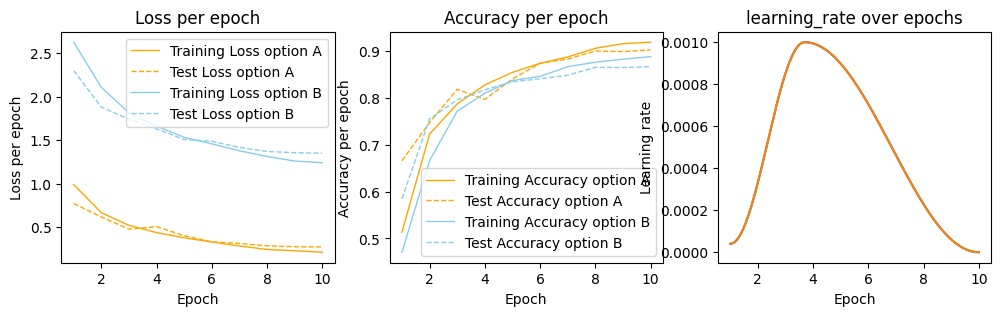

In [18]:
#Getting and plot metrics
plt.figure(figsize=(12,3))
#Option A
tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count = getting_metrics(results_A,EPOCHS)
plot_all_metrics(tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count,"option A")
#Option B
tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count = getting_metrics(results_B,EPOCHS)
plot_all_metrics(tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count,"option B",color="skyblue")

#. Evaluate models:

In [50]:
#Functions :
def eval_test(model_eval,testloader,OPTION_eval = "A",GPU =False):
  model_eval.eval()
  batch_losses, batch_accs=[],[]
  all_predictions, all_labels = [], []  # Pour la matrice de confusion
  i=0

  for images,labels in testloader:
    labels = convert_labels(labels,eq_df,old_label="label",new_label=f"label_{OPTION_eval}",GPU=GPU)
    predicted=model_eval(images)
    batch_losses.append(loss_func(predicted,labels))
    if OPTION_eval == "A":
      batch_accs.append(accuracy(predicted,labels,GPU=GPU))
    elif OPTION_eval == "B":
      batch_accs.append(accuracy_B(predicted,labels,GPU=GPU))

    # Collecter pour matrice de confusion
    _, preds = torch.max(predicted, 1)  # Classes prédites
    if OPTION_eval =="B":
      preds = convert_labels(preds,eq_df,old_label="label_B",new_label="label_A",GPU=GPU)
      labels = convert_labels(labels,eq_df,old_label="label_B",new_label="label_A",GPU=GPU)
    all_predictions.extend(preds.cpu().numpy())#all_predictions.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy()) #   all_labels.extend(labels.cpu().numpy())
  return all_predictions, all_labels
def plot_confusion_matrix(cm,SUPER_CLASSES,all_info = False,label=""):
  if all_info:
    print(classification_report(all_labels, all_predictions))
  # Plot de la matrice de confusion
  class_names = SUPER_CLASSES
  #plt.figure(figsize=(4, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names,yticklabels=class_names)
  plt.title(f'Matrice de Confusion {label}')
  plt.ylabel('Vraies labels')
  plt.xlabel('Prédictions')
  return cm

def predict_img(img,model,mode = "A",GPU="false"):
  model.eval()
  img = img.unsqueeze(0)
  if GPU:
    img = move_device(img, device)
  yb = model(img)
  _, pred = torch.max(yb, dim=1)
  if mode == "A":
    pred = pred.item()
  elif mode == "B":
    pred = convert_labels(pred,eq_df,old_label="label_B",new_label="label_A",GPU = GPU)
    pred = pred.item()
  return pred

def predict_and_show(img,label,model,mode = "A",GPU = "False"):
  pred = predict_img(img,model,mode=mode,GPU=GPU)
  #Getting Super Class name from ground truth and prediction
  pred_sc = eq_df[eq_df[f"label_{mode}"]==pred]["superclass"].values[0]
  label_sc = eq_df[eq_df["label"]==label]["superclass"].values[0]
  if GPU:
    img = img.cpu()
  img=img*0.5 +0.5 #Denormalize the img
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"gt: {label_sc}, pred :{pred_sc} ")
  return pred

In [42]:
#PARAMETERS and CKP option A
OPTION_eval = "A"
MODEL_eval = "conv"
PATH_CKP = '/content/model_A_optim_Adam_best_epoch_weights.pth'

print("Evaluation of model A")
model_eval_A = set_model(MODEL_eval,OPTION_eval,SUPER_CLASSES,train_df,GPU=GPU,FROM_CKP = True,CKP_PATH = PATH_CKP)
all_predictions_A, all_labels_A = eval_test(model_eval_A,testloader,OPTION_eval=OPTION_eval)
cm_A =   confusion_matrix(all_labels_A, all_predictions_A)

#PARAMETERS and CKP option B
OPTION_eval = "B"
MODEL_eval = "conv"
PATH_CKP = '/content/model_B_optim_Adam_best_epoch_weights.pth'

print("Evaluation of model B")
model_eval_B = set_model(MODEL_eval,OPTION_eval,SUPER_CLASSES,train_df,GPU=GPU,FROM_CKP = True,CKP_PATH = PATH_CKP)
all_predictions_B, all_labels_B = eval_test(model_eval_B,testloader,OPTION_eval=OPTION_eval)
cm_B =   confusion_matrix(all_labels_B, all_predictions_B)



Evaluation of model A
Evaluation of model B


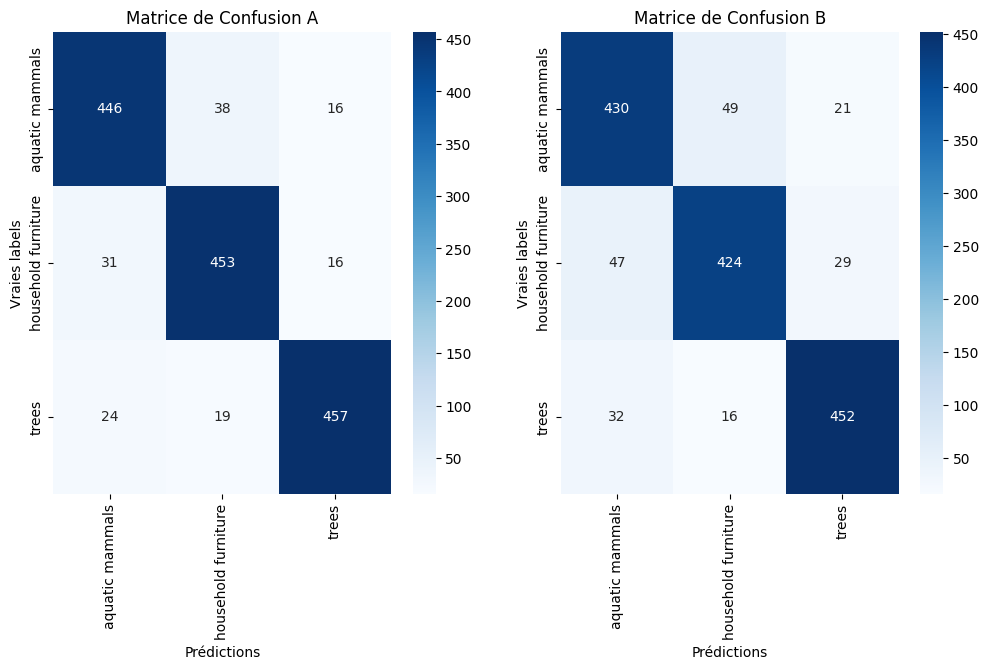

In [60]:
plt.figure(figsize=(12,6))
#Option A
plt.subplot(1,2,1)
cm_A = plot_confusion_matrix(cm_A,SUPER_CLASSES,label="A")
#Option B
plt.subplot(1,2,2)
cm_B = plot_confusion_matrix(cm_B,SUPER_CLASSES,label ="B")

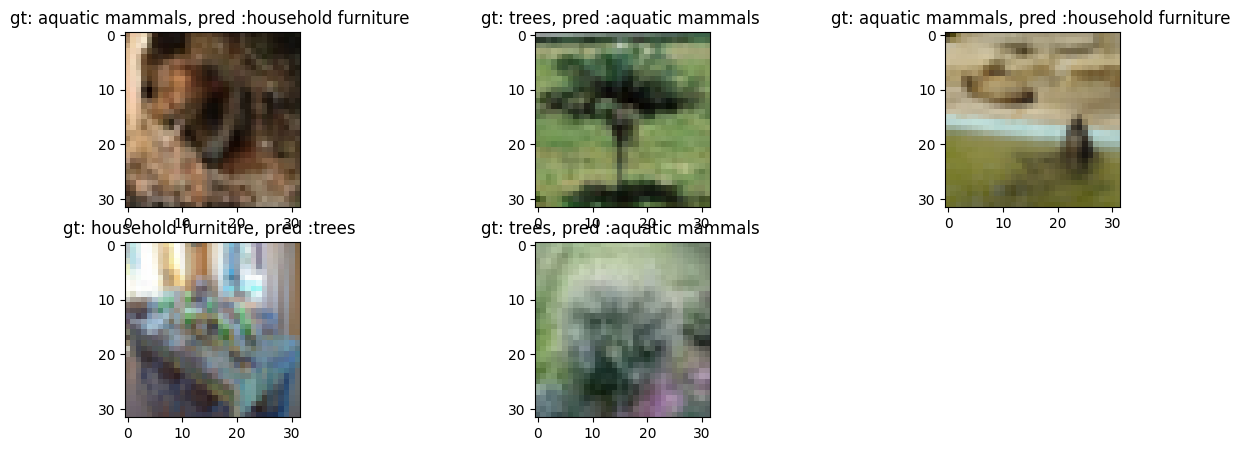

In [61]:
#List all wrong predictions
all_predictions = all_predictions_A
all_labels = all_labels_A
model_eval = model_eval_A

check_predict = np.equal(all_predictions,all_labels)
idx_false = np.where(check_predict == False)[0]

plt.figure(figsize=(15,5))
for i in range(5):

  #Observe some wrong predictions.
  idx_wrong = np.random.choice(idx_false)
  img,label = testset[idx_wrong]
  if GPU:
    img = move_device(img, device)
  plt.subplot(2,3,i+1)
  pred = predict_and_show(img,label,model_eval,GPU=GPU)